## 從Google抓取圖片

- https://github.com/ywchiu/largitdata/blob/master/code/Course_110.ipynb

In [0]:
import os
import requests
from bs4 import BeautifulSoup
# dataurl = 'https://www.google.com.tw/search?ei=MswPXJnSDMaT8wWwoozQDA&yv=3&q={}&tbm=isch&vet=10ahUKEwiZs6TsgJjfAhXGybwKHTARA8oQuT0IMigB.MswPXJnSDMaT8wWwoozQDA.i&ved=0ahUKEwiZs6TsgJjfAhXGybwKHTARA8oQuT0IMigB&ijn=1&start={}&asearch=ichunk&async=_id:rg_s,_pms:s,_fmt:pc'

def get_person_img(keyword, dstpath):
  dataurl = 'https://www.google.com.tw/search?ei=MswPXJnSDMaT8wWwoozQDA&yv=3&q={}&tbm=isch&vet=10ahUKEwiZs6TsgJjfAhXGybwKHTARA8oQuT0IMigB.MswPXJnSDMaT8wWwoozQDA.i&ved=0ahUKEwiZs6TsgJjfAhXGybwKHTARA8oQuT0IMigB&ijn=1&start={}&asearch=ichunk&async=_id:rg_s,_pms:s,_fmt:pc'
  for i in range(6):
    res = requests.get(dataurl.format(keyword, i * 100))
    soup = BeautifulSoup(res.text, 'lxml')
    for ele in soup.select('img'):
      imgurl = ele.get('src')
      if  imgurl is not None:
        fname  = imgurl.split('tbn:')[1]
        with open(dstpath + fname + '.jpg', 'wb') as f:
          res2 = requests.get(imgurl)
          f.write(res2.content)

In [0]:
if not os.path.exists('NiuChenZer/'):
    os.mkdir('NiuChenZer/')
get_person_img('鈕承澤', 'NiuChenZer/')

In [0]:
if not os.path.exists('ChuChungHeng'):
    os.mkdir('ChuChungHeng/')
get_person_img('屈中恆', 'ChuChungHeng/')

In [0]:
if not os.path.exists('SungShaoChing'):
    os.mkdir('SungShaoChing/')
get_person_img('宋少卿', 'SungShaoChing/')

## 擷取臉部圖片

In [0]:
#!pip install opencv-python

In [0]:
from PIL import Image
import cv2 as cv

In [0]:
def extractFace(srcpath, dstpath):
    if not os.path.exists(srcpath):
        os.mkdir(srcpath)
    if not os.path.exists(dstpath):
        os.mkdir(dstpath)
    face_cascade = cv.CascadeClassifier('/usr/local/lib/python3.6/dist-packages/cv2/data/haarcascade_frontalface_default.xml')
    for fname in os.listdir(srcpath):
        img = Image.open(srcpath + fname)
        imgary = cv.imread(srcpath + fname)
        faces = face_cascade.detectMultiScale(imgary, 1.3, 5)
        if len(faces) == 1:
            x,y,w,h = faces[0]
            crpim = img.crop((x,y, x + w, y + h)).resize((64,64))
            crpim.save(dstpath + fname)

In [0]:
srcpath = 'NiuChenZer/' 
dstpath = 'NiuChenZerFace/'
extractFace(srcpath, dstpath)

In [0]:
srcpath = 'ChuChungHeng/' 
dstpath = 'ChuChungHengFace/'
extractFace(srcpath, dstpath)

In [0]:
srcpath = 'SungShaoChing/' 
dstpath = 'SungShaoChingFace/'
extractFace(srcpath, dstpath)

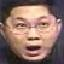

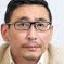

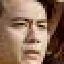

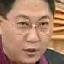

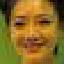

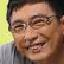

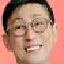

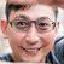

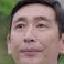

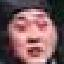

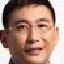

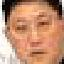

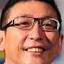

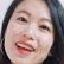

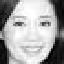

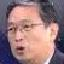

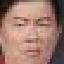

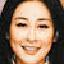

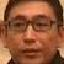

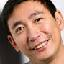

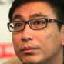

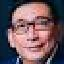

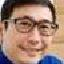

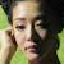

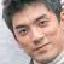

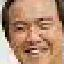

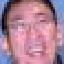

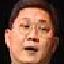

In [10]:
from glob import glob
from os.path import splitext
from google.colab.patches import cv2_imshow

jpglist = glob( dstpath +"*.[jJ][pP][gG]" )

for jpg in jpglist:
  im = cv.imread(jpg)
  cv2_imshow(im)


In [0]:
Image.open('ChuChungHengFace/ANd9GcQ1DB4MBigD8_phN_sExr2wUZP1VboZGUflEQax_GCOgkttzvjP&s.jpg')


## 以CNN進行人臉辨識

### 建立CNN模型

In [12]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [0]:
# Initialising the CNN
classifier = Sequential()

# Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64,3), activation = 'relu'))

# Max Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Convolution
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))

# Max Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))


# Flattening
classifier.add(Flatten())

# Fully Connected
classifier.add(Dense(units = 128, activation = 'relu')) 
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 3, activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

In [15]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1

### 讀入訓練與測試資料集

In [0]:
if not os.path.exists('training'):
    os.mkdir('training/')
if not os.path.exists('testing'):
  os.mkdir('testing/')

In [27]:
import os, random, shutil

# 三個資料夾各做一次
fileDir = "ChuChungHengFace/"
# fileDir = 'NiuChenZerFace/'
# fileDir = 'SungShaoChingFace/'
tarDir = 'training/'
count_sprit_training_sample = int(len([name for name in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, name))])*0.7)


if not os.path.exists('training/'+fileDir):
    os.mkdir('training/'+fileDir)
if not os.path.exists('testing'+fileDir):
  os.mkdir('testing/'+fileDir)


pathDir = os.listdir(fileDir)
sample = random.sample(pathDir,  count_sprit_training_sample)
print (sample)
for name in pathDir:
  if name  in sample:
    shutil.copyfile(fileDir+name, 'training/'+fileDir+name)
  else:
    shutil.copyfile(fileDir+name,'testing/'+fileDir+name)

# for name in sample:
# 	  shutil.copyfile(fileDir+name, 'training/'+name)


['ANd9GcR9QyM8gqz_gNJu_eHzEZVmwopFGQ-ADXceVVIHpsZWLgbzKC1ZmA&s.jpg', 'ANd9GcS26Te7NnNop02O4QRffdUNSZe8fibuZSA8ID9nLPsHOkpSXGym&s.jpg', 'ANd9GcSd5va_Upi6bDsa4AlPIjaVteuzdr9ghiSGWDqEH6WJBMzkIVwAcg&s.jpg', 'ANd9GcSVY46845BleIeTySw2grQUTy4fMai5lTKgncPxdsgL03CNc4uLuQ&s.jpg', 'ANd9GcQAnqQcxBAdFREt6eDr1SlbdcK5dViPE5HVMn729FrhS4PMOkOw&s.jpg', 'ANd9GcT6VWPOFS_xSOGsAFx62Eo5dyeCu70sQfa3sR2_G4WM0tgDaOHy&s.jpg', 'ANd9GcSAgraSqvGDT-3pYoq-xk6AQ2ebv7wLQJuACh8lKEEiPl_j8piT5Q&s.jpg', 'ANd9GcQ17tzc5NA3h6eDq2XBg6CVd_ps4JthqGn_0QaTG-l6_P-4-L2b&s.jpg', 'ANd9GcT8jKR9NBW3ITtVR1fCGYrbIjmdDrNbNDZ0m_-B5I6gNkhpV1ar&s.jpg', 'ANd9GcSLenftlBimi_Dik0DXLI59P-1GrII20symgVBfZ234AfyL9tO6&s.jpg', 'ANd9GcTsiGIuAd0jy2DIzdos2SaCL4YZLrQyF7SGujzLRMuZyOZltt44sw&s.jpg', 'ANd9GcTpuVDxUhWeMC_JFTFc-rQCHRo00DXmEXQi8oBemh0C-HUn-D3w&s.jpg', 'ANd9GcQOQaswJbZWumBaXrbj9ZBpT3KbX5XsgRkygWV-_kGf4JQZ8Qk5Iw&s.jpg', 'ANd9GcSPLR_5VEmosCguveVoWPktP82UXwhimQpYxDIKia48SrTLX5e3&s.jpg', 'ANd9GcRcyc_MLuJ1KrZSvv7Ypisang-X4pkAdTQyko8TKCCACJ0eL_6Y&s.jpg

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,     
                                   zoom_range = 0.2,      
                                   horizontal_flip = True 
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255)


In [29]:
training_set = train_datagen.flow_from_directory('training/', target_size = (64, 64),batch_size = 10,class_mode = 'categorical')


Found 84 images belonging to 3 classes.


In [30]:
test_set = test_datagen.flow_from_directory(    'testing/', target_size = (64, 64),    batch_size = 10,     class_mode = 'categorical')

Found 38 images belonging to 3 classes.


### 建立模型

In [31]:
history = classifier.fit(training_set,
                         epochs=100, 
                         validation_data = test_set)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 9 steps, validate for 4 steps
Epoch 1/100
9/9 [==============================] - 0s 23ms/step - loss: 423238.0555 - accuracy: 0.3095 - val_loss: 409861.2031 - val_accuracy: 0.4474
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 620841.6138 - accuracy: 0.3571 - val_loss: 996326.4062 - val_accuracy: 0.4474
Epoch 3/100
9/9 [==============================] - 0s 20ms/step - loss: 982426.5568 - accuracy: 0.3690 - val_loss: 1241340.9844 - val_accuracy: 0.3158
Epoch 4/100
9/9 [==============================] - 0s 18ms/step - loss: 959836.3358 - accuracy: 0.4524 - val_loss: 662038.7969 - val_accuracy: 0.3158
Epoch 5/100
9/9 [==============================] - 0s 19ms/step - loss: 1111499.9254 - accuracy: 0.2143 - val_loss: 1115557.2188 - val_accuracy: 0.3158
Epoch 6/100
9/9 [==============================] - 0s 19ms/step - loss: 1075395.2414 - accuracy: 0.3929 - val_loss: 1031091.5938 - val_accuracy: 0.3158
Epoch

### 辨識照片中出現的明星

In [22]:
!wget -O whoami.jpg https://i.imgur.com/WjkQA7l.jpg

--2020-02-19 15:16:20--  https://i.imgur.com/WjkQA7l.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.40.193
Connecting to i.imgur.com (i.imgur.com)|151.101.40.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92459 (90K) [image/jpeg]
Saving to: ‘whoami.jpg’

whoami.jpg          100%[===================>]  90.29K   268KB/s    in 0.3s    

2020-02-19 15:16:21 (268 KB/s) - ‘whoami.jpg’ saved [92459/92459]



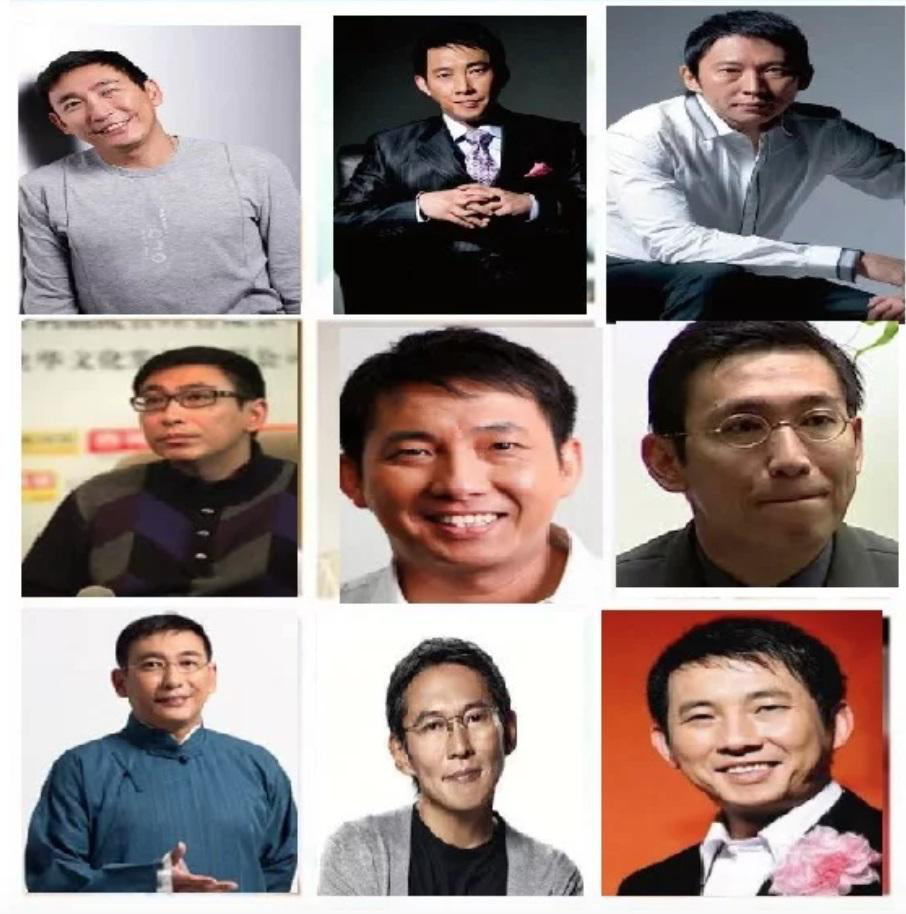

In [23]:
from PIL import Image
im = Image.open('whoami.jpg')
im

In [24]:
from PIL import Image
import cv2 as cv
face_cascade = cv.CascadeClassifier('/usr/local/lib/python3.6/dist-packages/cv2/data/haarcascade_frontalface_default.xml')

img = cv.imread('whoami.jpg')
faces = face_cascade.detectMultiScale(img, 1.2, 3)
faces

array([[424,  42,  77,  77],
       [702,  33,  97,  97],
       [126, 363,  99,  99],
       [688, 349, 190, 190],
       [354, 370, 202, 202],
       [124, 627,  93,  93],
       [658, 647, 164, 164],
       [393, 673, 124, 124]], dtype=int32)

In [32]:
transform_dic = {
    'ChuChungHengFace'  : 'Chu Chung-Heng',
    'NiuChenZerFace'    : 'Niu Chen-Zer',
    'SungShaoChingFace' : 'Sung Shao-Ching'
}
name_dic = {v:transform_dic.get(k) for k,v in training_set.class_indices.items()}
name_dic

{0: 'Chu Chung-Heng', 1: 'Niu Chen-Zer', 2: 'Sung Shao-Ching'}

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt 
font = cv.FONT_HERSHEY_PLAIN
for x,y,w,h in faces:
    box = (x, y, x+w, y+h)
    crpim = im.crop(box).resize((64,64))
    target_image = image.img_to_array(crpim)
    target_image = np.expand_dims(target_image, axis = 0)
    res = classifier.predict_classes(target_image)[0]
    cv.rectangle(img,(x,y),(x+w,y+h),(14,201,255),2)
    cv.putText(img,name_dic.get(res), (x + int(w/3)-70, y-10), font, 1.5, (14,201,255), 3)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['box', 'random', 'sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


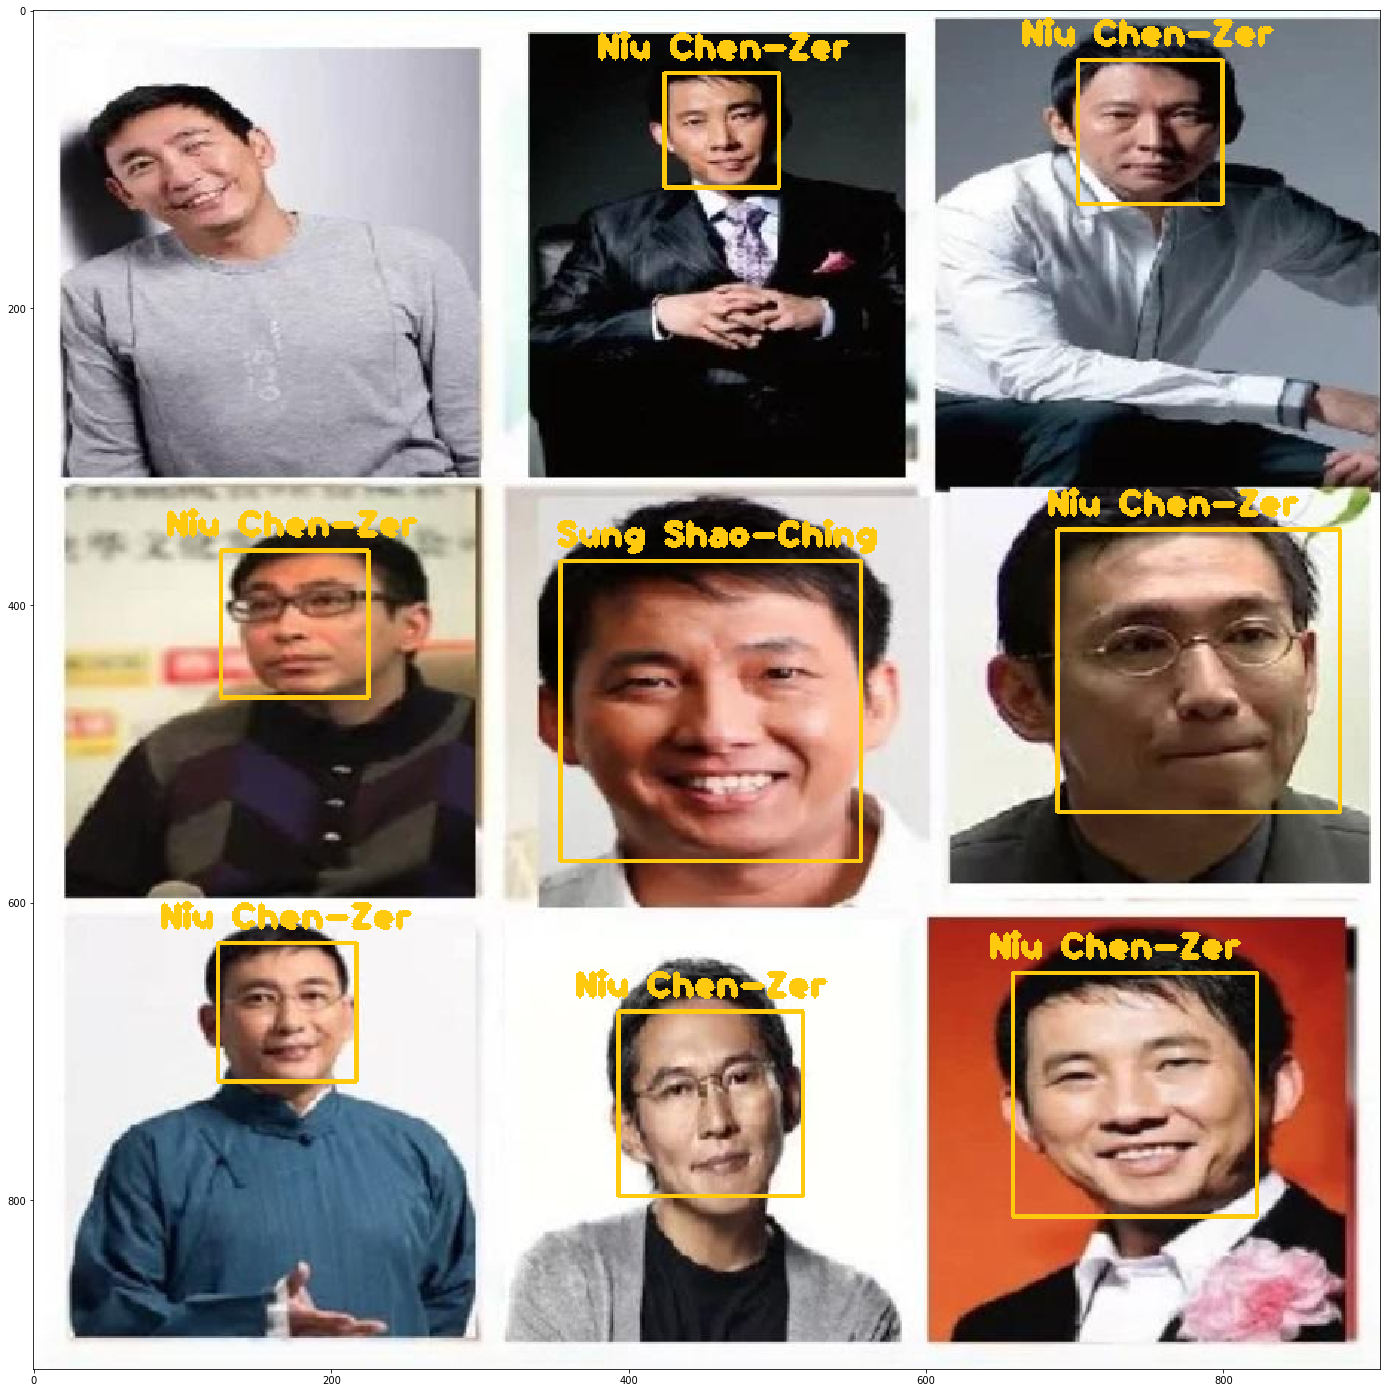

In [34]:
%pylab inline
plt.figure(figsize=(30,25))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

# 參考
- https://github.com/ywchiu/largitdata/blob/master/code/Course_110.ipynb